In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set path to google drive
path ="/content/drive/MyDrive/Colab Notebooks/Group_Project_2/LTC_USD_data.csv"


In [5]:
# Read CSV file
data = pd.read_csv(path)

In [6]:
# To see data
data.head()

,Date,LTC
0,6/28/17,42.04
1,6/29/17,40.50
2,6/30/17,39.88
3,7/1/17,38.10
4,7/2/17,41.42


In [7]:
# Prep. data frame
data.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,LTC
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


In [8]:
# Slicing the date range
eth_df = data.loc['2020-03-02':'2021-05-03']
eth_df.head()

,LTC
Date,
2020-03-02,61.38
2020-03-03,60.87
2020-03-04,60.28
2020-03-05,61.86
2020-03-06,63.29


In [9]:
# Rename the column name
df_1=eth_df.rename(columns={"LTC": "Close"})
df_1.head()

,Close
Date,
2020-03-02,61.38
2020-03-03,60.87
2020-03-04,60.28
2020-03-05,61.86
2020-03-06,63.29


In [10]:
# Reset index
df = df_1.reset_index()
df.head()

,Date,Close
0,2020-03-02,61.38
1,2020-03-03,60.87
2,2020-03-04,60.28
3,2020-03-05,61.86
4,2020-03-06,63.29


In [11]:
# Add exponential and rolling moving averages
df['EMA_5'] = df['Close'].ewm(5).mean().shift()
df['EMA_10'] = df['Close'].ewm(10).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()



In [13]:
# Set definition to calcluate RSI
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)


In [14]:
# Add MACD (Moving Average Convergence Divergence)
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-02,61.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,60.87,61.380000,61.380000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2020-03-04,60.28,61.101818,61.112857,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2020-03-05,61.86,60.776703,60.808399,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2020-03-06,63.29,61.125425,61.109989,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
423,2021-04-29,255.79,251.618625,247.750619,243.226,249.149,262.652667,241.995000,39.484717,6.923080,9.982173
424,2021-04-30,271.54,252.313854,248.481472,249.324,248.571,261.240667,243.995000,36.742772,7.951635,9.576065
425,2021-05-01,276.80,255.518212,250.577702,258.840,249.620,260.217333,246.493667,41.020496,9.086467,9.478145
426,2021-05-02,269.29,259.065176,252.961547,264.640,251.491,258.067333,248.976667,48.214286,9.272942,9.437105


In [15]:
# Split stock data frame into three subsets: training ( 95% ), validation ( 2.5% ) and test ( 2.5% ) sets

test_size  = 0.025
valid_size = 0.025

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

train_df.tail()

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
402,2021-04-08,226.27,209.038788,202.837959,215.128,207.604,198.400000,200.608000,72.057994,7.954346,4.146328
403,2021-04-09,220.90,211.910657,204.968144,221.304,210.862,201.739333,201.350333,65.833689,8.164149,4.949892
404,2021-04-10,226.20,213.408881,206.416495,224.984,213.373,205.032667,202.035000,67.206942,8.658279,5.691569
405,2021-04-11,252.00,215.540734,208.214995,225.904,216.335,207.861333,202.861333,72.890302,11.004867,6.754229
406,2021-04-12,244.68,221.617278,212.195450,228.884,221.304,212.384000,203.904667,67.492281,12.134018,7.830187


In [16]:
# Drop unnecessary columns

train_df = train_df.drop(columns=["Date"])
valid_df = valid_df.drop(columns=["Date"])
test_df  = test_df.drop(columns=["Date"])

train_df.head()

,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,61.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60.87,61.380000,61.380000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,60.28,61.101818,61.112857,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,61.86,60.776703,60.808399,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,63.29,61.125425,61.109989,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [18]:
# Set X_train, y_train, X_valid, y_valid, X_test, and y_test
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407 entries, 0 to 406
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_5        406 non-null    float64
 1   EMA_10       406 non-null    float64
 2   SMA_5        402 non-null    float64
 3   SMA_10       397 non-null    float64
 4   SMA_15       392 non-null    float64
 5   SMA_30       377 non-null    float64
 6   RSI          406 non-null    float64
 7   MACD         382 non-null    float64
 8   MACD_signal  374 non-null    float64
dtypes: float64(9)
memory usage: 28.7 KB


In [20]:
# Set the parameters
parameters = {
  # Number of boosted trees to fit
     'n_estimators': [1],  
  # boosting learning rate
     'learning_rate': [0.001], 
  # Maximum tree depth for base learnes    
     'max_depth': [5],        
    'random_state': [1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False, parameters=parameters)
# objective='reg:squarederror' outputs regression with squared loss

In [21]:
# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_set=[(          EMA_5      EMA_10    SMA_5  ...        RSI       MACD  MACD_signal
0           NaN         NaN      NaN  ...        NaN        NaN          NaN
1     61.380000   61.380000      NaN  ...   0.000000        NaN          NaN
2     61.101818   61.112857      NaN  ...   0.000000        NaN          NaN
3     60.776703   60.808399      NaN  ...   0.000000        NaN          NaN
4     61.125425   61.109989      NaN  ...   0.000000        NaN          NaN
..          ...         ...      ...  ...        ...        ...          ....
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror',
             parameters={'learning_rate': [0.001], 'max_depth': [5],
     

In [22]:
# Run predict
y_pred = model.predict(X_test)

In [24]:
# Define model evaluation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=1)
# Evaluate model to calculate mean absolute error
scores = cross_val_score(model, X_test, y_pred, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# Force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# Calculate R2 (mean_square_error) to evaluate predictions
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

Mean MAE: 2.678 (2.969)
mean_squared_error = 3365.926746769187


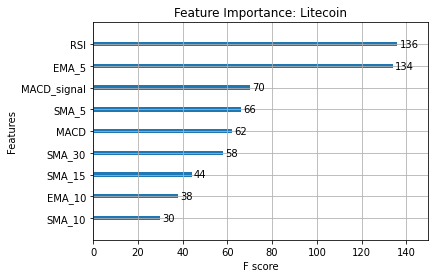

In [31]:
# Plot feature importance
plot_importance(model, title ='Feature Importance: Litecoin');

In [26]:
# Prep to create a dataframe for the predicted value and actual closing price
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
predicted_prices.Date
date_pred=pd.DataFrame(predicted_prices.Date)
date_pred=date_pred.reset_index(drop=True)
# Make the predicted value to DataFrame
amazon_pred = pd.DataFrame(y_pred)
# Make X_test value to DataFrame
actual=pd.DataFrame(y_test) 
actual_f=actual.reset_index(drop=True)
actual_f
# combine date, closing price and predict value
actual_pred = pd.concat([date_pred, actual_f, amazon_pred], axis=1)

# Set the column name for the Predicted value
actual_pred.rename( columns={0 :'Pred'}, inplace=True )
# calculate the difference and squar of diff.
actual_pred['Diff'] = actual_pred['Close'] - actual_pred['Pred']
actual_pred['Square'] = actual_pred['Diff']**2
actual_pred

,Date,Close,Pred,Diff,Square
0,2021-04-24,225.30,203.350586,21.949414,481.776778
1,2021-04-25,223.96,198.171432,25.788568,665.050214
2,2021-04-26,247.80,203.908386,43.891614,1926.473759
3,2021-04-27,260.19,204.341263,55.848737,3119.081445
4,2021-04-28,258.88,204.341263,54.538737,2974.473853
5,2021-04-29,255.79,198.517120,57.272880,3280.182742
6,2021-04-30,271.54,198.517120,73.022880,5332.340951
7,2021-05-01,276.80,198.457336,78.342664,6137.572936
8,2021-05-02,269.29,204.281479,65.008521,4226.107818
9,2021-05-03,294.57,220.298828,74.271172,5516.206972


In [29]:
# Calculate the total of diffeences
column_sum = actual_pred['Diff'].sum()
print(f"Total differences {column_sum}")
# Calculate the mean squared error
MSE = actual_pred['Square'].mean()
print(f"Mean Squared Error {MSE}")
# Compute the root-mean-square
rms = np.sqrt(MSE)
print(f"Root Mean Square {rms}")
# Calculate the mean of the closing prices
ClosingPrice = actual_pred['Close'].mean()
print(f"Mean Closing Price {ClosingPrice}")

Total differences 549.935185546875
Mean Squared Error 3365.926746769187
Root Mean Square 58.01660750827462
Mean Closing Price 258.41200000000003


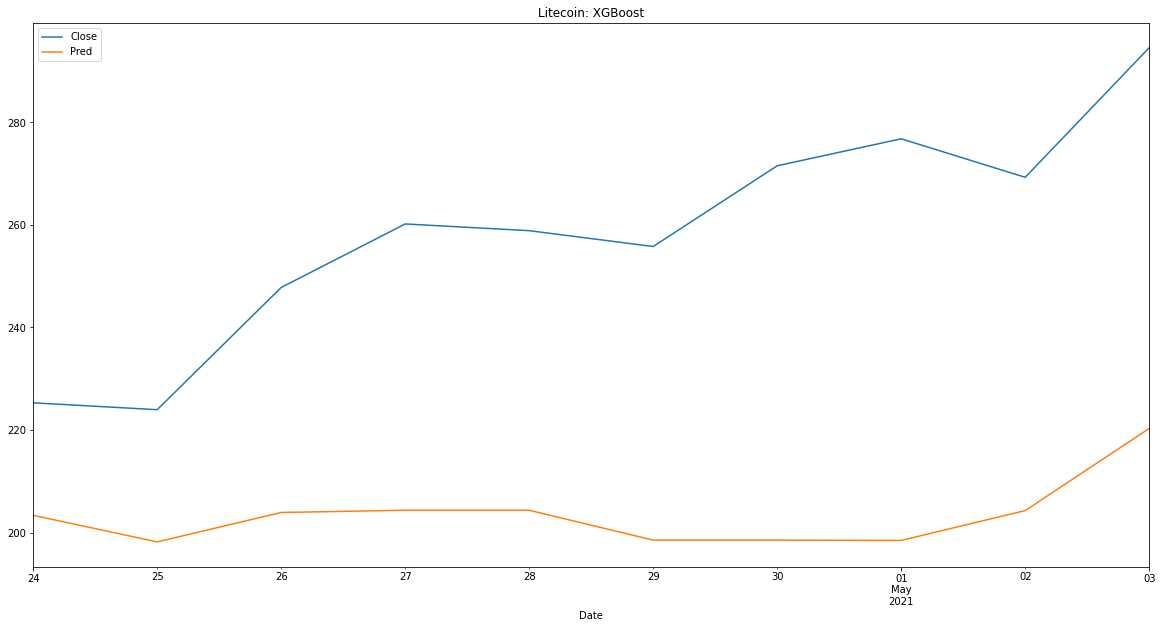

In [32]:
# Plot the closing price and predicted price
actual_pred.plot.line(x="Date", y=["Close", "Pred"],title="Litecoin: XGBoost", figsize=(20,10));

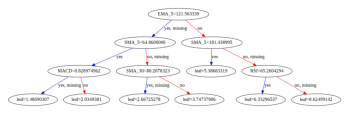

In [33]:
# Plot tree
plot_tree(model, num_trees=10);